In [1]:
!pip install nnsight tqdm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from nnsight import NNsight
import copy
import numpy as np

import nnsight
from tqdm import tqdm
from matplotlib import pyplot as plt

In [3]:
class DeepDecoder(nn.Module):
    def __init__(
        self,
        num_output_channels = 3,
        num_channels_up = [128]*5,
        filter_size_up = 1,
        activation_function = nn.ReLU(),
        need_sigmoid = True,
        pad = 'reflection',
        upsample_first = True,
        upsample_mode = 'bilinear',
        bn_before_act = False,
        bn_affine = True):

        super(DeepDecoder, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        '''
        Adding last two layers to the decoder with same last layer size given as input
        Example : if input is [128,128] it is transformed to [128,128,128,128]
        '''
        self.num_channels_up = num_channels_up + [num_channels_up[-1],num_channels_up[-1]]
        # layers
        self.n_scales = len(self.num_channels_up)

        '''
        Need a value for each layer which must have length of .
        Example: [3,3,3]
        '''
        if not (isinstance(filter_size_up, list) or isinstance(filter_size_up, tuple)) :
          self.filter_size_up = [filter_size_up] * self.n_scales

        self.layers = nn.Sequential()
        self.dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

        for i in range(len(self.num_channels_up)-1):

            if upsample_first:
                self.layers.append(self.conv( self.num_channels_up[i], self.num_channels_up[i+1],  self.filter_size_up[i], 1, pad=pad))
                if upsample_mode!='none' and i != len(self.num_channels_up)-2:
                    self.layers.append(nn.Upsample(scale_factor=2, mode=upsample_mode))
            else:
                if upsample_mode!='none' and i!=0:
                    self.layers.append(nn.Upsample(scale_factor=2, mode=upsample_mode))
                self.layers.append(self.conv( self.num_channels_up[i], self.num_channels_up[i+1],  self.filter_size_up[i], 1, pad=pad))

            if i != len(self.num_channels_up)-1:
                if(bn_before_act):
                    self.layers.append(nn.BatchNorm2d( self.num_channels_up[i+1] ,affine=bn_affine))
                self.layers.append(activation_function)
                if(not bn_before_act):
                    self.layers.append(nn.BatchNorm2d( self.num_channels_up[i+1], affine=bn_affine))

        self.layers.append(self.conv( self.num_channels_up[-1], num_output_channels, 1, pad=pad))
        if need_sigmoid:
            self.layers.append(nn.Sigmoid())

    def exp_lr_scheduler(self, optimizer, epoch, init_lr=0.001, lr_decay_epoch=500):
        """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
        lr = init_lr * (0.65**(epoch // lr_decay_epoch))

        if epoch % lr_decay_epoch == 0:
            print('LR is set to {}'.format(lr))

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        return optimizer

    def fit(
        self,
        img_noisy_var,
        num_channels,
        img_clean_var,
        num_iter=5000,
        LR=0.01,
        OPTIMIZER='adam',
        opt_input=False,
        reg_noise_std=0,
        reg_noise_decayevery=100000,
        mask_var=None,
        apply_f=None,
        lr_decay_epoch=0,
        net_input=None,
        net_input_gen="random",
        find_best=False,
        weight_decay=0,
    ):
      net = self.to(self.device)

      img_noisy_var = img_noisy_var.to(self.device)
      img_clean_var = img_clean_var.to(self.device)

      if net_input != None:
        print("input provided")
      else:
        totalupsample = 2**len(num_channels)
        width = int(img_clean_var.data.shape[2]/totalupsample)
        height = int(img_clean_var.data.shape[3]/totalupsample)
        shape = [1,num_channels[0], width, height]
        print("shape: ", shape)
        net_input = torch.zeros(shape)
        net_input.data.uniform_()
        net_input.data *= 1./10

      net_input = net_input.to(self.device)
      net_input_saved = net_input.clone().to(self.device)
      noise = net_input.clone().to(self.device)

      p = [x for x in net.parameters() ]

      if(opt_input == True): # optimizer over the input as well
        net_input.requires_grad = True
        p += [net_input]

      mse_wrt_noisy = np.zeros(num_iter)
      mse_wrt_truth = np.zeros(num_iter)

      if OPTIMIZER == 'SGD':
          print("optimize with SGD", LR)
          optimizer = torch.optim.SGD(p, lr=LR,momentum=0.9,weight_decay=weight_decay)
      elif OPTIMIZER == 'adam':
          print("optimize with adam", LR)
          optimizer = torch.optim.Adam(p, lr=LR,weight_decay=weight_decay)
      elif OPTIMIZER == 'LBFGS':
          print("optimize with LBFGS", LR)
          optimizer = torch.optim.LBFGS(p, lr=LR)

      mse = torch.nn.MSELoss() #.type(dtype)
      noise_energy = mse(img_noisy_var, img_clean_var)

      if find_best:
          best_net = copy.deepcopy(net)
          best_mse = 1000000.0
      pbar = tqdm(range(num_iter), desc='Starting training...')
      for i in pbar:
          if lr_decay_epoch != 0:
              optimizer = self.exp_lr_scheduler(optimizer, i, init_lr=LR, lr_decay_epoch=lr_decay_epoch)
          if reg_noise_std > 0:
              if i % reg_noise_decayevery == 0:
                  reg_noise_std *= 0.7
              net_input = net_input_saved + (noise.normal_() * reg_noise_std)

          def closure():
              optimizer.zero_grad()
              out = net(net_input)
              # training loss
              if mask_var != None:
                  loss = mse( out * mask_var , img_noisy_var * mask_var )
              elif apply_f:
                  loss = mse( apply_f(out) , img_noisy_var )
              else:
                  loss = mse(out, img_noisy_var)

              loss.backward()
              mse_wrt_noisy[i] = loss.item()

              # the actual loss
              true_loss = mse(out.detach(), img_clean_var)
              mse_wrt_truth[i] = true_loss.item()
              if i % 10 == 0:
                  out2 = net(net_input_saved)
                  loss2 = mse(out2, img_clean_var)
                  #print ('Iteration %05d    Train loss %f  Actual loss %f Actual loss orig %f  Noise Energy %f' % (i, loss.item(),true_loss.item(),loss2.item(),noise_energy.item()), '\r', end='')
                  pbar.set_description('T-loss: %.6f | Act-loss: %.6f | Noise Eneg: %.6f' % (loss.item(), true_loss.item(), noise_energy.item()))
              return loss

          loss = optimizer.step(closure)

          if find_best:
              # if training loss improves by at least 0.5 percent, we found a new best net
              if best_mse > 1.005*loss.data:
                  best_mse = loss.data
                  best_net = copy.deepcopy(net)

      if find_best:
          net = best_net

      return mse_wrt_noisy, mse_wrt_truth,net_input_saved, net



    def conv(self, in_f, out_f, kernel_size, stride=1, pad='zero'):
        padder = None
        to_pad = int((kernel_size - 1) / 2)
        if pad == 'reflection':
            padder = nn.ReflectionPad2d(to_pad)
            to_pad = 0

        convolver = nn.Conv2d(in_f, out_f, kernel_size, stride, padding=to_pad, bias=False)

        layers = filter(lambda x: x != None, [padder, convolver])
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


In [4]:
def np_to_tensor(img_np):
    '''Converts image in numpy.array to torch.Tensor.

    From C x W x H [0..1] to  C x W x H [0..1]
    '''
    return torch.from_numpy(img_np)

def np_to_var(img_np, dtype=torch.float32, device='cuda'):
    '''Converts image in numpy.array to torch.Tensor with an additional batch dimension.

    From C x W x H [0..1] to  1 x C x W x H [0..1]
    '''
    # return Variable(np_to_tensor(img_np)[None, :])
    tensor = np_to_tensor(img_np).to(dtype=dtype, device=device)
    return tensor.unsqueeze(0)

def get_noisy_img(img_np, dtype=torch.float32, sig=30, noise_same = False):
    sigma = sig/255.
    if noise_same: # add the same noise in each channel
        noise = np.random.normal(scale=sigma, size=img_np.shape[1:])
        noise = np.array( [noise]*img_np.shape[0] )
    else: # add independent noise in each channel
        noise = np.random.normal(scale=sigma, size=img_np.shape)

    img_noisy_np = np.clip( img_np + noise , 0, 1).astype(np.float32)
    img_noisy_var = np_to_var(img_noisy_np).type(dtype)
    return img_noisy_np, img_noisy_var

def pil_to_np(img_PIL):
    '''Converts image in PIL format to np.array.

    From W x H x C [0...255] to C x W x H [0..1]
    '''
    ar = np.array(img_PIL)

    if len(ar.shape) == 3:
        ar = ar.transpose(2,0,1)
    else:
        ar = ar[None, ...]

    return ar.astype(np.float32) / 255.

In [5]:
from PIL import Image
import PIL

In [6]:
img_pil = Image.open("/content/sample.jpg")
resize_transform = transforms.Resize((512, 512))
img_pil = resize_transform(img_pil)
img_np = pil_to_np(img_pil)
img_clean_var = np_to_var(img_np)

In [7]:
img_noisy_np,img_noisy_var = get_noisy_img(img_np)
output_depth = img_np.shape[0]
print("Image size: ", img_np.shape)

Image size:  (3, 512, 512)


In [8]:
net = DeepDecoder(
    output_depth,
    num_channels_up=[128]*5
    )

Using device: cuda


In [9]:
mse_n, mse_t, ni, net = net.fit(
    num_channels = [128]*5,
    reg_noise_std = 0.0,
    num_iter = 1900,
    img_noisy_var = img_noisy_var,
    img_clean_var = img_clean_var,
    find_best = True
)



shape:  [1, 128, 16, 16]
optimize with adam 0.01


T-loss: 0.007968 | Act-loss: 0.001506 | Noise Eneg: 0.009028: 100%|██████████| 1900/1900 [01:31<00:00, 20.83it/s]


In [10]:
out_img_np = net( ni).detach().cpu().numpy()[0]

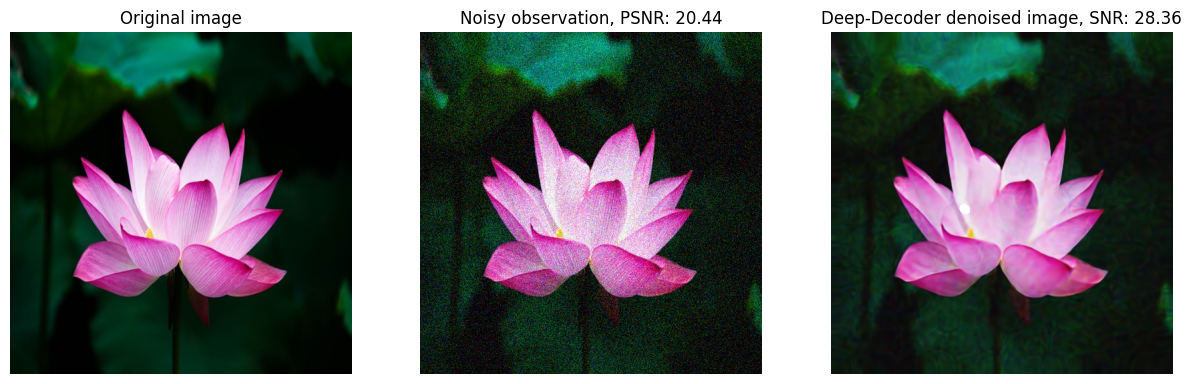

In [11]:
def psnr(x_hat,x_true,maxv=1.):
    x_hat = x_hat.flatten()
    x_true = x_true.flatten()
    mse=np.mean(np.square(x_hat-x_true))
    psnr_ = 10.*np.log(maxv**2/mse)/np.log(10.)
    return psnr_

def myimgshow(plt,img):
    plt.imshow(np.clip(img.transpose(1, 2, 0),0,1))

def plot_results(out_img_np,img_np,img_noisy_np):
    fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure

    ax1 = fig.add_subplot(131)
    myimgshow(ax1,img_np)
    ax1.set_title('Original image')
    ax1.axis('off')

    ax2 = fig.add_subplot(132)
    myimgshow(ax2,img_noisy_np)
    ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_np,img_noisy_np) )
    ax2.axis('off')

    ax3 = fig.add_subplot(133)
    myimgshow(ax3,out_img_np)
    ax3.set_title( "Deep-Decoder denoised image, SNR: %.2f" % psnr(img_np,out_img_np) )
    ax3.axis('off')

    plt.show()


plot_results(out_img_np,img_np,img_noisy_np)